In [2]:
%pip install opencv-python

   ---------------------------------------- 38.1/38.1 MB 12.6 MB/s eta 0:00:00
Note: you may need to restart the kernel to use updated packages.


In [2]:
import os
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from tensorflow.keras.preprocessing.image import load_img, img_to_array
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping
import cv2
from sklearn.metrics import classification_report, confusion_matrix, roc_auc_score, roc_curve, precision_recall_curve, auc
import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve, auc

In [3]:
# Load CSV file
csv_path = 'E:/STA 221/surfline_photo_labels.csv'
df = pd.read_csv(csv_path)

# Set image directory
img_dir = 'E:/STA 221/all_surfline_photos/'

In [4]:
# Convert labels to lowercase
df['Label'] = df['Label'].str.lower()

# Drop rows with label "uncertain" in-place
df.drop(df[df['Label'] == 'uncertain'].index, inplace=True)

label_encoder = LabelEncoder()
df['Label'] = label_encoder.fit_transform(df['Label'])
df.loc[df['Label'] != 'uncertain']

,Url,Label,LabelConfidence,link,photo
0,AmlDatastore://workspaceblobstore/UI/2023-07-1...,1,1,2023_05-18.0730_agatebeachor.jpg,2023_05-18.0730_agatebeachor.jpg
1,AmlDatastore://workspaceblobstore/UI/2023-07-1...,1,1,2023_05-03.1930_agatebeachor.jpg,2023_05-03.1930_agatebeachor.jpg
2,AmlDatastore://workspaceblobstore/UI/2023-07-1...,1,1,2023_05-18.1630_agatebeachor.jpg,2023_05-18.1630_agatebeachor.jpg
3,AmlDatastore://workspaceblobstore/UI/2023-07-1...,1,1,2023_05-18.2030_agatebeachor.jpg,2023_05-18.2030_agatebeachor.jpg
5,AmlDatastore://workspaceblobstore/UI/2023-07-1...,1,1,2023_05-30.2100_agatebeachor.jpg,2023_05-30.2100_agatebeachor.jpg
...,...,...,...,...,...
8932,AmlDatastore://workspaceblobstore/UI/2023-10-2...,0,1,2022_09-28.2100_otterrockor.jpg,2022_09-28.2100_otterrockor.jpg
8933,AmlDatastore://workspaceblobstore/UI/2023-10-2...,1,1,2023_08-20.1400_otterrockor.jpg,2023_08-20.1400_otterrockor.jpg
8934,AmlDatastore://workspaceblobstore/UI/2023-10-2...,0,1,2022_08-18.1900_agatebeachor.jpg,2022_08-18.1900_agatebeachor.jpg
8935,AmlDatastore://workspaceblobstore/UI/2023-10-2...,1,1,2023_06-14.1130_cannonbeach.jpg,2023_06-14.1130_cannonbeach.jpg


In [5]:
df.drop(df[df['photo'] == '2023_07-31.1800_cannonbeach.jpg'].index, inplace=True)

In [6]:
original_labels = label_encoder.classes_
print(original_labels)

['foggy' 'not_foggy']


In [7]:
label_counts = df['Label'].value_counts()

print("Label Counts:")
print(label_counts)

Label Counts:
1    6853
0    1776
Name: Label, dtype: int64


In [8]:
display(df)

,Url,Label,LabelConfidence,link,photo
0,AmlDatastore://workspaceblobstore/UI/2023-07-1...,1,1,2023_05-18.0730_agatebeachor.jpg,2023_05-18.0730_agatebeachor.jpg
1,AmlDatastore://workspaceblobstore/UI/2023-07-1...,1,1,2023_05-03.1930_agatebeachor.jpg,2023_05-03.1930_agatebeachor.jpg
2,AmlDatastore://workspaceblobstore/UI/2023-07-1...,1,1,2023_05-18.1630_agatebeachor.jpg,2023_05-18.1630_agatebeachor.jpg
3,AmlDatastore://workspaceblobstore/UI/2023-07-1...,1,1,2023_05-18.2030_agatebeachor.jpg,2023_05-18.2030_agatebeachor.jpg
5,AmlDatastore://workspaceblobstore/UI/2023-07-1...,1,1,2023_05-30.2100_agatebeachor.jpg,2023_05-30.2100_agatebeachor.jpg
...,...,...,...,...,...
8932,AmlDatastore://workspaceblobstore/UI/2023-10-2...,0,1,2022_09-28.2100_otterrockor.jpg,2022_09-28.2100_otterrockor.jpg
8933,AmlDatastore://workspaceblobstore/UI/2023-10-2...,1,1,2023_08-20.1400_otterrockor.jpg,2023_08-20.1400_otterrockor.jpg
8934,AmlDatastore://workspaceblobstore/UI/2023-10-2...,0,1,2022_08-18.1900_agatebeachor.jpg,2022_08-18.1900_agatebeachor.jpg
8935,AmlDatastore://workspaceblobstore/UI/2023-10-2...,1,1,2023_06-14.1130_cannonbeach.jpg,2023_06-14.1130_cannonbeach.jpg


In [9]:
# Count of each class
label_counts = df['Label'].value_counts()

# Number of data points to drop from the "non-foggy" class
num_to_drop = 5077

# Check if the number to drop is greater than the count of "non-foggy" class
if num_to_drop > label_counts[1]:
    print("Warning: The specified number of data points to drop is greater than the count of 'foggy' class.")
else:
    # Randomly drop data points from the "non-foggy" class
    df_to_drop = df[df['Label'] == 1].sample(n=num_to_drop, random_state=42)
    df_filtered = df.drop(df_to_drop.index)

    # Display the resulting DataFrame
    print(df_filtered)
    print(label_counts)


                                                    Url  Label  \
2     AmlDatastore://workspaceblobstore/UI/2023-07-1...      1   
3     AmlDatastore://workspaceblobstore/UI/2023-07-1...      1   
5     AmlDatastore://workspaceblobstore/UI/2023-07-1...      1   
6     AmlDatastore://workspaceblobstore/UI/2023-07-1...      1   
11    AmlDatastore://workspaceblobstore/UI/2023-07-1...      1   
...                                                 ...    ...   
8924  AmlDatastore://workspaceblobstore/UI/2023-10-2...      0   
8927  AmlDatastore://workspaceblobstore/UI/2023-10-2...      0   
8930  AmlDatastore://workspaceblobstore/UI/2023-10-2...      0   
8932  AmlDatastore://workspaceblobstore/UI/2023-10-2...      0   
8934  AmlDatastore://workspaceblobstore/UI/2023-10-2...      0   

      LabelConfidence                               link  \
2                   1   2023_05-18.1630_agatebeachor.jpg   
3                   1   2023_05-18.2030_agatebeachor.jpg   
5                   1   202

In [10]:
label_counts = df_filtered['Label'].value_counts()

print("Label Counts:")
print(label_counts)

Label Counts:
1    1776
0    1776
Name: Label, dtype: int64


In [11]:
# Load images and labels
data = []
labels = []

for index, row in df.iterrows():
    img_path = os.path.join(img_dir, row['photo'])
    try:
        img = load_img(img_path, target_size=(100, 100))  # Specify the target size of your images
    except Exception as e:
        print(f"Error loading image {img_path}: {e}")
    img_array = img_to_array(img)

    # Edge detection using Canny algorithm
    gray_image = cv2.cvtColor(img_array.astype('uint8'), cv2.COLOR_RGB2GRAY)
    edges = cv2.Canny(gray_image, threshold1=30, threshold2=100)

    # Stack the original image and edges as input
    img_with_edges = np.dstack([img_array, edges])
    
    data.append(img_with_edges)
    labels.append(row['Label'])

KeyboardInterrupt: 

In [ ]:
# Convert lists to numpy arrays
data = np.array(data)
labels = np.array(labels)

# Ensure labels are in the format 0 or 1 for binary classification
labels = labels.astype(int)

In [ ]:
# Normalize pixel values to be between 0 and 1
data = data / 255.0

In [ ]:
# Perform train-test split
X_train, X_test, y_train, y_test = train_test_split(data, labels, test_size=0.2, random_state=42)


In [ ]:
len(X_train)

In [12]:
# Build CNN Model
model = Sequential()

model.add(Conv2D(32, (3, 3), activation='relu', input_shape=(100, 100, 4)))
model.add(MaxPooling2D((2, 2)))

model.add(Conv2D(64, (3, 3), activation='relu'))
model.add(MaxPooling2D((2, 2)))

model.add(Conv2D(128, (3, 3), activation='relu'))
model.add(MaxPooling2D((2, 2)))

model.add(Flatten())
model.add(Dense(128, activation='relu'))
model.add(Dense(1, activation='sigmoid'))  # For binary classification

# Compile the model with specified learning rate
opt = Adam(learning_rate=0.01)
model.compile(optimizer=opt, loss='binary_crossentropy', metrics=['accuracy'])

# Display model summary
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 98, 98, 32)        1184      
                                                                 
 max_pooling2d (MaxPooling2D  (None, 49, 49, 32)       0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 47, 47, 64)        18496     
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 23, 23, 64)       0         
 2D)                                                             
                                                                 
 conv2d_2 (Conv2D)           (None, 21, 21, 128)       73856     
                                                                 
 max_pooling2d_2 (MaxPooling  (None, 10, 10, 128)      0

In [14]:
%pip install pydot

Note: you may need to restart the kernel to use updated packages.


In [16]:
from keras.utils import plot_model
plot_model(model, to_file='cnn_model.png', show_shapes=True, show_layer_names=True)

You must install pydot (`pip install pydot`) and install graphviz (see instructions at https://graphviz.gitlab.io/download/) for plot_model to work.


In [21]:
# Early Stopping
early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)

# Train the Model
history = model.fit(X_train, y_train, epochs=10, batch_size=32, validation_data=(X_test, y_test), callbacks=[early_stopping])

# Evaluate the Model
accuracy = model.evaluate(X_test, y_test)[1]
print(f'Test Accuracy: {accuracy * 100:.2f}%')


Epoch 1/10
216/216 [==============================] - 75s 337ms/step - loss: 0.6505 - accuracy: 0.8567 - val_loss: 0.2680 - val_accuracy: 0.8986
Epoch 2/10
216/216 [==============================] - 71s 327ms/step - loss: 0.2476 - accuracy: 0.9060 - val_loss: 0.2318 - val_accuracy: 0.9108
Epoch 3/10
216/216 [==============================] - 71s 327ms/step - loss: 0.2373 - accuracy: 0.9105 - val_loss: 0.2302 - val_accuracy: 0.9096
Epoch 4/10
216/216 [==============================] - 71s 328ms/step - loss: 0.2327 - accuracy: 0.9140 - val_loss: 0.2378 - val_accuracy: 0.9050
Epoch 5/10
216/216 [==============================] - 70s 323ms/step - loss: 0.2149 - accuracy: 0.9166 - val_loss: 0.2168 - val_accuracy: 0.9108
Epoch 6/10
216/216 [==============================] - 69s 321ms/step - loss: 0.2004 - accuracy: 0.9213 - val_loss: 0.2128 - val_accuracy: 0.9102
Epoch 7/10
216/216 [==============================] - 70s 325ms/step - loss: 0.1920 - accuracy: 0.9219 - val_loss: 0.2474 - val_ac

In [22]:
# Display additional metrics
y_pred = model.predict(X_test)
y_pred_binary = (y_pred > 0.5).astype(int)

print("Classification Report:")
print(classification_report(y_test, y_pred_binary))

54/54 [==============================] - 8s 125ms/step
Classification Report:
              precision    recall  f1-score   support

           0       0.72      0.82      0.77       338
           1       0.95      0.92      0.94      1388

    accuracy                           0.90      1726
   macro avg       0.84      0.87      0.85      1726
weighted avg       0.91      0.90      0.90      1726



In [23]:
def plot_confusion_matrix(y_test, y_test_pred, model_name):
  test_confusion_matrix = confusion_matrix(y_test, y_test_pred)
  group_names = ['True Negative (TN)', 'False Positive (FP)',
                'False Negative (FN)', 'True Positive (TP)']
  group_counts = ["{0:0.0f}".format(value) for value in test_confusion_matrix.flatten()]
  group_percentages = ["{0:.2%}".format(value) for value in test_confusion_matrix.flatten()/np.sum(test_confusion_matrix)]

  labels = [f"{v1}\n{v2}\n{v3}" for v1, v2, v3 in zip(group_names, group_counts, group_percentages)]
  labels = np.asarray(labels).reshape(2,2)

  # Creating the heatmap
  plt.figure(figsize=(10,7))
  sns.heatmap(test_confusion_matrix, annot=labels, fmt='', cmap='Blues')
  plt.title("Confusion Matrix for "+ model_name+ " (using Test Set)")
  plt.ylabel('True label')
  plt.xlabel('Predicted label')

  plt.show()

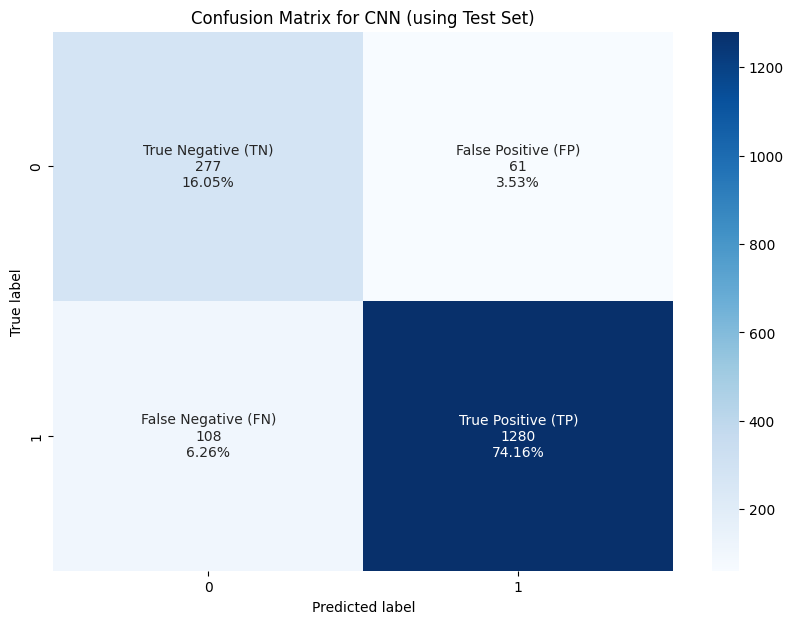

In [24]:
# Confusion Matrix
import seaborn as sns

plot_confusion_matrix(y_test, y_pred_binary, "CNN")


In [25]:
# ROC Curve
fpr, tpr, _ = roc_curve(y_test, y_pred)
roc_auc = auc(fpr, tpr)

In [28]:
# Precision-Recall Curve
precision, recall, _ = precision_recall_curve(y_test, y_pred)
pr_auc = auc(recall, precision)

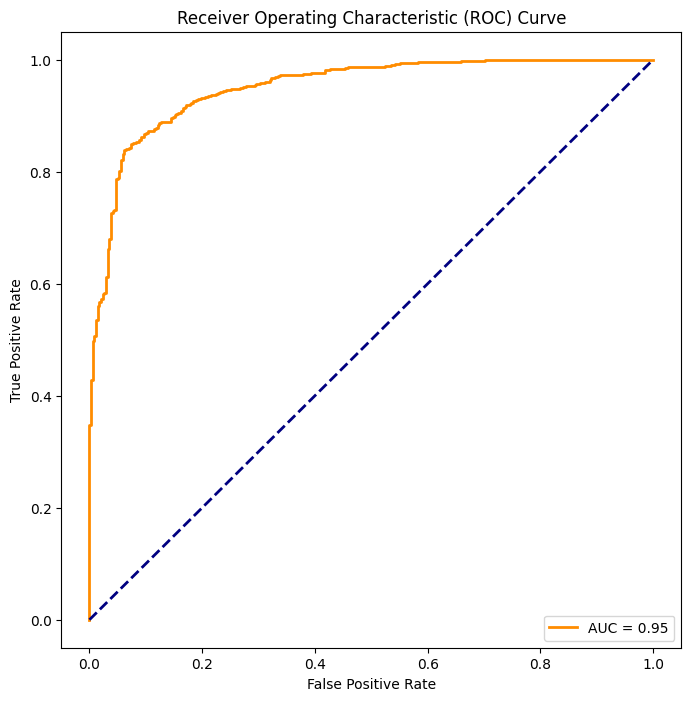

In [29]:
# Plot ROC Curve
plt.figure(figsize=(8, 8))
plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'AUC = {roc_auc:.2f}')
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc='lower right')
plt.show()

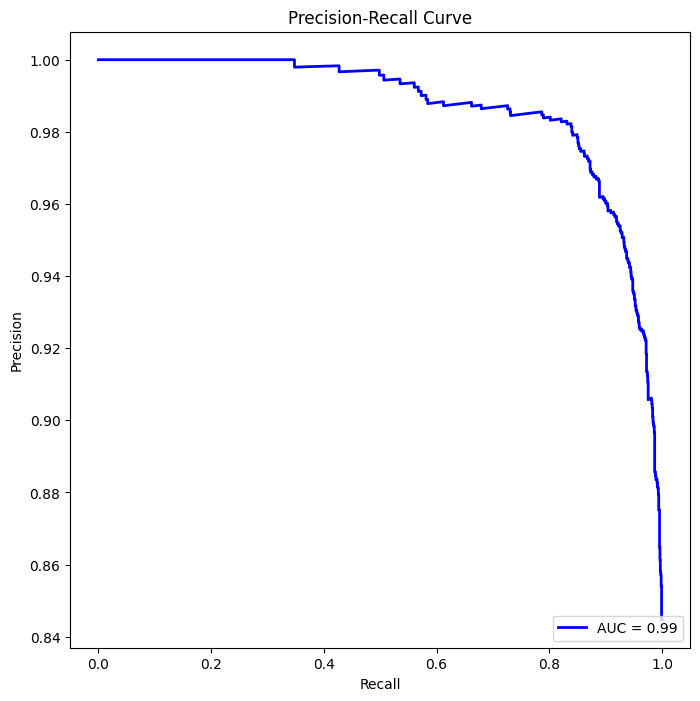

In [30]:
# Plot Precision-Recall Curve
plt.figure(figsize=(8, 8))
plt.plot(recall, precision, color='blue', lw=2, label=f'AUC = {pr_auc:.2f}')
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Precision-Recall Curve')
plt.legend(loc='lower right')
plt.show()